# Drilling Activity Prediction: Data Modeling - VARMA

- Load datasets and resample to monthly frequency
- Use oil dataset to make predictions on Oil Rig Count:
    - Get second order differencing data frame (stationary features dataframe) 
    - Train/test split
    - VARMA Model Hyperparameter selection
    - Fit the model
    - Invert Transformation
    - Generate forecast values and plot results
    - Evaluation Metrics
    - Fit the model again but with 100% of the data
    - Forecast real future values


- Use gas dataset to make predictions on Gas Rig Count:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load specific forecasting tools
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, mse, meanabs
from sklearn.model_selection import TimeSeriesSplit
import time
from pylab import rcParams
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
# Size of all plots
rcParams['figure.figsize'] = 6,6

In [2]:
dfoil = pd.read_csv('dfoil.csv',index_col=0,parse_dates=True)
dfoil = dfoil.resample('M').mean()
dfoil.index.freq = 'M'


dfgas = pd.read_csv('dfgas.csv',index_col=0,parse_dates=True)
dfgas = dfgas.resample('M').mean()
dfgas.index.freq = 'M'

A $K$-dimensional VARMA model of order $(p,q)$ considers each variable $y_K$ in the system.<br>

For example, the system of equations for a 2-dimensional VARMA(1,1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \theta_{11,1}\varepsilon_{1,t-1} + \theta_{12,1}\varepsilon_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \theta_{21,1}\varepsilon_{1,t-1} + \theta_{22,1}\varepsilon_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\theta_{ii,l}$ captures the influence of the $l$th lag of error $\varepsilon_i$ on itself,<br>
the coefficient $\theta_{ij,l}$ captures the influence of the $l$th lag of error $\varepsilon_j$ on $\varepsilon_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are residual white noise.<br>

The order (2,2) is the one that we have been using so far. This means differencing to second level order to guarantee 
stationarity of all features (We used Augmented Dicky Fuller Tests for this).

#### Get second order differencing data frame (stationary features dataframe)

In [3]:
dfoil_transformed = dfoil.diff().diff()
dfoil_transformed = dfoil_transformed.dropna()
dfoil_transformed.head()

,oilrig_count,oil_price,oilconsumption,oilproduction,oilstorage
1997-03-31,-7.056452,1.312871,481.072565,-72.177714,-6540.096313
1997-04-30,-8.104032,0.182258,-152.485198,92.726362,2345.221198
1997-05-31,10.490323,2.344355,424.190083,-43.429157,-3579.112903
1997-06-30,-9.318280,-2.697634,-138.891237,-14.576469,-2234.476344
1997-07-31,3.823656,1.878333,-50.252335,-5.380888,-9928.515054


#### Train/test split

- We will evaluate the model forecasting 12 months ahead (1 year)
- Train test split. Test df will have 12 data points

In [4]:
"""
nobs is the variable that will be used to determine the number of months to predict.
"""

nobs=12
train, test = dfoil_transformed[0:-nobs], dfoil_transformed[-nobs:]

#### Fit VARMA model

In [5]:
oil_model = VARMAX(train, order=(2,2), trend='ctt')
oil_results = oil_model.fit(maxiter=1000, disp=False)
oil_results.summary()

Dep. Variable:,"['oilrig_count', 'oil_price', 'oilconsumption', 'oilproduction', 'oilstorage']",No. Observations:,284
Model:,"VARMA(2,2)",Log Likelihood,-9057.796
,+ intercept,AIC,18375.592
Date:,"Sun, 21 Nov 2021",BIC,18849.959
Time:,11:22:32,HQIC,18565.776
Sample:,03-31-1997,,
,- 10-31-2020,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.83, 0.34, 4.51, 0.50, 1.34",Jarque-Bera (JB):,"1895.97, 37.73, 803.86, 953.23, 0.11"
Prob(Q):,"0.36, 0.56, 0.03, 0.48, 0.25",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.95"
Heteroskedasticity (H):,"4.99, 3.84, 2.31, 2.58, 1.97",Skew:,"-1.68, -0.14, -1.08, 0.03, 0.03"


#### Generate Forecast values and plot results

- Create forecasts of differenced dataframe
- Invert dataframe transformation
- Plot results and compare Forecasted values Vs Test set

In [6]:
#12 months forecast
dfoil_forecast = oil_results.forecast(nobs)
dfoil_forecast

,oilrig_count,oil_price,oilconsumption,oilproduction,oilstorage
2020-11-30,-4.280394,-1.435711,-695.481553,-182.799444,-7846.901445
2020-12-31,-13.202206,-0.066545,-60.069108,139.041036,-2688.598486
2021-01-31,-2.123777,1.368484,264.122033,-56.779543,4217.805805
2021-02-28,4.743731,-0.386538,-66.416784,-4.966729,259.075275
2021-03-31,4.193703,0.064971,113.294082,12.344146,-1984.705119
2021-04-30,1.370701,-0.352358,15.953364,-12.571195,-932.333185
2021-05-31,-0.750705,-0.350336,-1.390188,1.909956,-405.332549
2021-06-30,-0.404127,0.093711,53.540804,-7.021171,-247.747746
2021-07-31,0.831223,-0.001021,36.703984,-5.345431,-382.825801
2021-08-31,1.371113,-0.082420,42.388808,-1.618196,-563.186966


In [7]:
#Invert dataframe transformation
dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-nobs-1]-dfoil['oilrig_count'].iloc[-nobs-2])+dfoil_forecast['oilrig_count'].cumsum()
dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-nobs-1] + dfoil_forecast['oilrig_count1d'].cumsum()

<AxesSubplot:title={'center':'Oil Rig Count Prediction: FORECAST vs TEST Set - VARMA'}>

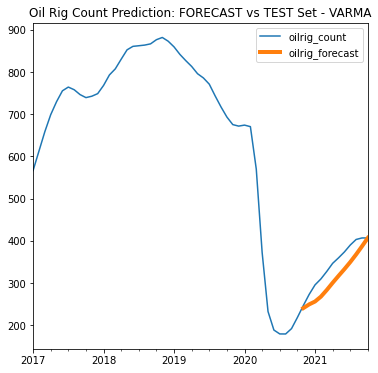

In [8]:
dfoil['oilrig_count'].loc['2017':].plot(legend=True)
dfoil_forecast['oilrig_forecast'].plot(legend=True,linewidth=4,title='Oil Rig Count Prediction: FORECAST vs TEST Set - VARMA')

#### Evaluation Metrics

In [9]:
RMSE1 = rmse(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
MSE1 = mse(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
MAE1 = meanabs(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])

print(f"""Oil Rig VARMA(2,2) RMSE: {RMSE1:.3f}
Oil Rig VARMA(2,2) MSE: {MSE1:.3f}
Oil Rig VARMA(2,2) MAE: {MAE1:.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE1/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

Oil Rig VARMA(2,2) RMSE: 35.022
Oil Rig VARMA(2,2) MSE: 1226.545
Oil Rig VARMA(2,2) MAE: 31.681

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 10.150%


In [10]:
tscv = TimeSeriesSplit(n_splits=10, test_size=12)
RMSE_oil = []
MSE_oil = []
MAE_oil = []
for train_index, test_index in tscv.split(dfoil_transformed):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    train,test = dfoil_transformed.loc[dfoil_transformed.index[train_index],:], dfoil_transformed.loc[dfoil_transformed.index[test_index],:]
    oil_model = VARMAX(train, order=(2,2), trend='ctt')
    oil_results = oil_model.fit(maxiter=1000, disp=False)
    dfoil_forecast = oil_results.forecast(nobs)
    dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-nobs-1]-dfoil['oilrig_count'].iloc[-nobs-2])+dfoil_forecast['oilrig_count'].cumsum()
    dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-nobs-1] + dfoil_forecast['oilrig_count1d'].cumsum()
    RMSE_oil.append('{:.3f}'.format(rmse(dfoil.loc[dfoil.index[test_index],'oilrig_count'],dfoil_forecast['oilrig_forecast'])))
    MSE_oil.append('{:.3f}'.format(mse(dfoil.loc[dfoil.index[test_index],'oilrig_count'],dfoil_forecast['oilrig_forecast'])))
    MAE_oil.append('{:.3f}'.format(meanabs(dfoil.loc[dfoil.index[test_index],'oilrig_count'],dfoil_forecast['oilrig_forecast'])))

RMSE_oil = np.array(RMSE_oil).astype('float')
MSE_oil = np.array(MSE_oil).astype('float')
MAE_oil = np.array(MAE_oil).astype('float')
print(f"""\n10-fold Cross Validation Oil Rig
RMSE: {RMSE_oil.mean():.3f},
MSE: {MSE_oil.mean():.3f}
MAE: {MAE_oil.mean():.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE_oil.mean()/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

TRAIN: 176 TEST: 12
TRAIN: 188 TEST: 12
TRAIN: 200 TEST: 12
TRAIN: 212 TEST: 12
TRAIN: 224 TEST: 12
TRAIN: 236 TEST: 12
TRAIN: 248 TEST: 12
TRAIN: 260 TEST: 12
TRAIN: 272 TEST: 12
TRAIN: 284 TEST: 12

10-fold Cross Validation Oil Rig
RMSE: 543.836,
MSE: 437414.838
MAE: 521.412

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 157.608%


#### Fit Model with 100% of Data and forecast Real Future

In [11]:
startTime = time.time()
oil_model = VARMAX(dfoil_transformed, order=(2,2), trend='ctt')
oil_results = oil_model.fit(maxiter=1000, disp=False)
dfoil_forecast = oil_results.forecast(nobs)
dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-1]-dfoil['oilrig_count'].iloc[-2])+dfoil_forecast['oilrig_count'].cumsum()
dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-1] + dfoil_forecast['oilrig_count1d'].cumsum()
executionTime = (time.time() - startTime)
oil_results.summary()

Dep. Variable:,"['oilrig_count', 'oil_price', 'oilconsumption', 'oilproduction', 'oilstorage']",No. Observations:,296
Model:,"VARMA(2,2)",Log Likelihood,-9482.614
,+ intercept,AIC,19225.228
Date:,"Sun, 21 Nov 2021",BIC,19704.975
Time:,11:39:43,HQIC,19417.309
Sample:,03-31-1997,,
,- 10-31-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.91, 0.40, 5.88, 0.55, 1.44",Jarque-Bera (JB):,"2058.68, 37.70, 697.26, 559.51, 0.60"
Prob(Q):,"0.34, 0.53, 0.02, 0.46, 0.23",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.74"
Heteroskedasticity (H):,"4.76, 3.45, 2.35, 5.24, 2.24",Skew:,"-1.65, -0.18, -0.94, 0.07, 0.11"


In [12]:
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 147.76382875442505


<AxesSubplot:title={'center':'Oil Rig Count Prediction: REAL FORECAST - VARMA'}>

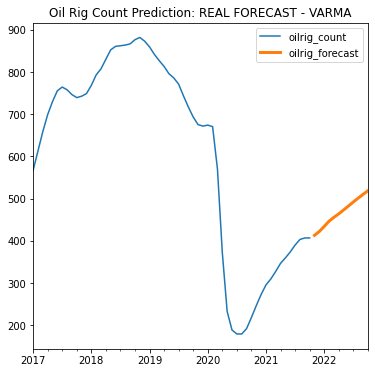

In [13]:
dfoil['oilrig_count'].loc['2017':].plot(legend=True)
dfoil_forecast['oilrig_forecast'].plot(legend=True,linewidth=3,title='Oil Rig Count Prediction: REAL FORECAST - VARMA')

#### Create model with Gas Rig Counts

In [14]:
dfgas.columns

Index(['gasrig_count', 'gas_price', 'gaswell_count', 'gasimports_amount',
       'gasconsumption_amount'],
      dtype='object')

In [15]:
dfgas_transformed = dfgas.diff().diff()
dfgas_transformed = dfgas_transformed.dropna()

Evaluation Metrics Gas Rig Count VARMA Model:

In [16]:
train, test = dfgas_transformed[0:-nobs], dfoil_transformed[-nobs:]
gas_model = VARMAX(train, order=(2,2),trend='ctt')
gas_results = gas_model.fit(maxiter=1000, disp=False)
dfgas_forecast = gas_results.forecast(nobs)
dfgas_forecast['gasrig_count1d'] = (dfgas['gasrig_count'].iloc[-nobs-1]-dfgas['gasrig_count'].iloc[-nobs-2])+dfgas_forecast['gasrig_count'].cumsum()
dfgas_forecast['gasrig_forecast'] = dfgas['gasrig_count'].iloc[-nobs-1] + dfgas_forecast['gasrig_count1d'].cumsum()

<AxesSubplot:title={'center':'Gas Rig Count Prediction: Forecast Vs Test set - VARMA'}>

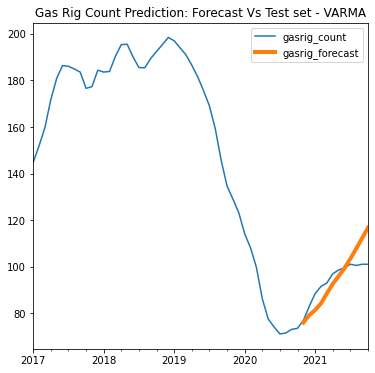

In [17]:
dfgas['gasrig_count'].loc['2017':].plot(legend=True)
dfgas_forecast['gasrig_forecast'].plot(legend=True,linewidth=4,title='Gas Rig Count Prediction: Forecast Vs Test set - VARMA')

In [18]:
RMSE2 = rmse(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])
MSE2 = mse(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])
MAE2 = meanabs(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])

print(f"""Gas Rig VARMA(2,2) RMSE: {RMSE2:.3f}
Gas Rig VARMA(2,2) MSE: {MSE2:.3f}
Gas Rig VARMA(2,2) MAE: {MAE2:.3f}\n
Gas Rig Mean Value: {dfgas['gasrig_count'][-nobs:].mean():.3f}
Gas Rig std Value: {dfgas['gasrig_count'][-nobs:].std():.3f}
Gas Rig Percent Change: {RMSE2/dfgas['gasrig_count'][-nobs:].mean()*100:.3f}%""")

Gas Rig VARMA(2,2) RMSE: 7.045
Gas Rig VARMA(2,2) MSE: 49.629
Gas Rig VARMA(2,2) MAE: 5.611

Gas Rig Mean Value: 94.254
Gas Rig std Value: 7.984
Gas Rig Percent Change: 7.474%


In [19]:
tscv = TimeSeriesSplit(n_splits=10, test_size=12)
RMSE_gas = []
MSE_gas = []
MAE_gas = []
for train_index, test_index in tscv.split(dfoil_transformed):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    train,test = dfgas_transformed.loc[dfgas_transformed.index[train_index],:], dfgas_transformed.loc[dfgas_transformed.index[test_index],:]
    gas_model = VARMAX(train, order=(2,2), trend='ctt')
    gas_results = gas_model.fit(maxiter=1000, disp=False)
    dfgas_forecast = gas_results.forecast(nobs)
    dfgas_forecast['gasrig_count1d'] = (dfgas['gasrig_count'].iloc[-nobs-1]-dfgas['gasrig_count'].iloc[-nobs-2])+dfgas_forecast['gasrig_count'].cumsum()
    dfgas_forecast['gasrig_forecast'] = dfgas['gasrig_count'].iloc[-nobs-1] + dfgas_forecast['gasrig_count1d'].cumsum()
    RMSE_gas.append('{:.3f}'.format(rmse(dfgas.loc[dfgas.index[test_index],'gasrig_count'],dfgas_forecast['gasrig_forecast'])))
    MSE_gas.append('{:.3f}'.format(mse(dfgas.loc[dfgas.index[test_index],'gasrig_count'],dfgas_forecast['gasrig_forecast'])))
    MAE_gas.append('{:.3f}'.format(meanabs(dfgas.loc[dfgas.index[test_index],'gasrig_count'],dfgas_forecast['gasrig_forecast'])))

RMSE_gas = np.array(RMSE_gas).astype('float')
MSE_gas = np.array(MSE_gas).astype('float')
MAE_gas = np.array(MAE_gas).astype('float')
print(f"""\n10-fold Cross Validation Gas Rig
RMSE: {RMSE_gas.mean():.3f},
MSE: {MSE_gas.mean():.3f}
MAE: {MAE_gas.mean():.3f}\n
Gas Rig Mean Value: {dfgas['gasrig_count'][-nobs:].mean():.3f}
Gas Rig std Value: {dfgas['gasrig_count'][-nobs:].std():.3f}
Gas Rig Percent Change: {RMSE_gas.mean()/dfgas['gasrig_count'][-nobs:].mean()*100:.3f}%""")

TRAIN: 176 TEST: 12
TRAIN: 188 TEST: 12
TRAIN: 200 TEST: 12
TRAIN: 212 TEST: 12
TRAIN: 224 TEST: 12
TRAIN: 236 TEST: 12
TRAIN: 248 TEST: 12
TRAIN: 260 TEST: 12
TRAIN: 272 TEST: 12
TRAIN: 284 TEST: 12

10-fold Cross Validation Gas Rig
RMSE: 213.752,
MSE: 87621.795
MAE: 209.565

Gas Rig Mean Value: 94.254
Gas Rig std Value: 7.984
Gas Rig Percent Change: 226.782%


Forecast Real Future

In [20]:
gas_model = VARMAX(dfgas_transformed, order=(2,2),trend='ctt')
gas_results = gas_model.fit(maxiter=1000, disp=False)
dfgas_forecast = gas_results.forecast(nobs)
dfgas_forecast['gasrig_count1d'] = (dfgas['gasrig_count'].iloc[-1]-dfgas['gasrig_count'].iloc[-2])+dfgas_forecast['gasrig_count'].cumsum()
dfgas_forecast['gasrig_forecast'] = dfgas['gasrig_count'].iloc[-1] + dfgas_forecast['gasrig_count1d'].cumsum()

<AxesSubplot:title={'center':'Gas Rig Count Prediction: REAL FORECAST - VARMA'}>

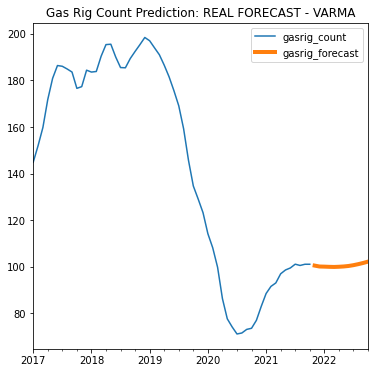

In [21]:
dfgas['gasrig_count'].loc['2017':].plot(legend=True)
dfgas_forecast['gasrig_forecast'].plot(legend=True,linewidth=4,title='Gas Rig Count Prediction: REAL FORECAST - VARMA')